In [2]:
# google colab/notebook libraries
from IPython.display import display, Javascript, Image
# from google.colab.output import eval_js
# from google.colab.patches import cv2_imshow

# external libraries
import glob
import os
import cv2
from tqdm import tqdm
import pickle
import shapely
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


from IPython.display import HTML
from IPython.display import Image as _image
from IPython.display import Video

import warnings


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    horizontal-align: middle;
    vertical-align: middle;
    margin:auto;
}

tbody, thead {
    margin-left:100px;
}

</style>
<form action="javascript:code_toggle()"><input type="submit"
value="Click here to toggle on/off the raw code."></form>''')

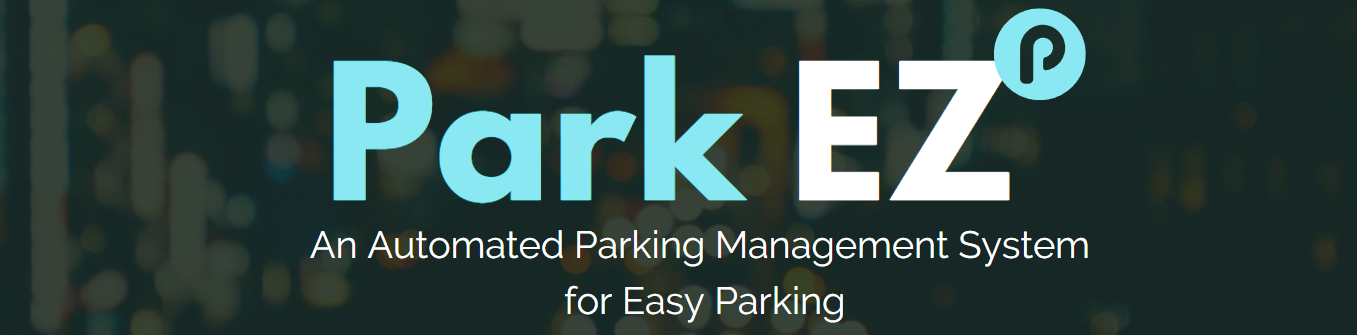

In [10]:
display(Image(filename="img/header.PNG"))

<h2 style='background-color:#122926'><font color='#89e8f1'> Executive Summary </font></h2>

<p style="text-align:justify">Parking management systems tend to inconvenience customers and serve as cost centers to business owners. Park EZ remedies these pains by serving as a parking management system alternative which automates the entire process for the customer while reducing the costs needed from the owner.</p>

<p style="text-align:justify">Current automated parking management systems (PMS) involve sensors and computer systems which entail high costs. This project aims to be a jump off point in creating a PMS that relies only on CCTV camera feeds, which are commonly available in these establishments, and methods in computer vision.</p>

<p style="text-align:justify">The team sampled 156 frames from a CCTV footage of a parking lot, then train a custom YOLO model to detect cars with these manually labeled sampled images as training and validation set, The team created a rule based on the manually labeled irregular quadrilaterals for each of the parking spaces and the detected cars based on its Intersection Over Union (IoU) and its coordinates to decide if the parking space is taken or vacant. In order to attach a timer to each car, we located the centroid of each car and assigned a car id into it then time for each frame that the car id is in the view of the camera.</p>

<p style="text-align:justify">The application of transfer learning on YOLO has allowed for high precision of 100% on the validation set with fast detection. This allows for robust and real-time detection when deployed as a real-time car tracker. Thresholding for values for rules is dependent on the camera angle and distinguishes between parked cars and edge cases. Together with the timer and unique ID, Park EZ presents a proof of concept for a real time parking management system optimized custom for that parking lot.</p>

<p style="text-align:justify">Recommendations for this project involve additional features outside the current scope of the study but builds on the aspect of a fully developed parking management system for end-to-end deployment. To further improve this implementation, the authors suggest exploring security monitoring, deployment within a camera network, and a user app. Additional recommendations involve alternative use cases for the system. With modifications to the implementation, this system may be redeployed for employee monitoring, security systems, and traffic management.</p>

<h2 style='background-color:#122926'><font color='#89e8f1'> I. Introduction </font></h2>

<p style="text-align:justify">The pandemic did not change one of the daily challenges faced by Filipinos especially in the metro, which is parking. In 2021, vehicle sales in the Philippines picked up by almost 20% (Canivel, 2022) compared to the previous year. This is amidst the need for private modes of transport due to the implications of the pandemic and because of this we may infer that parking related problems are just going to get worse.</p>
    
<p style="text-align:justify">Parking has always been a struggle in the urbanized Metro Manila. Drivers have to deal with driving around one parking lot to another to look for unoccupied slots while fumbling with their assigned parking cards. Here is where parking management systems come in. Parking management systems refer to the real-time parking facility usage monitoring, which can be manual or automated using sensors. Some of these functions of PMS include slot occupancy counts and payment systems. Automated parking management systems include both hardware and software to function. Bulk of the cost for these systems are associated with the hardware component, or the sensors.</p>
    
<p style="text-align:justify">Park EZ is a parking management system that does away with the inconveniences for the customers just like other automated PMS but reduces costs for the business owner. This implementation leverages computer vision to track unique vehicles and unoccupied parking slots just through the perspective of a camera feed.</p>

<h3 style='background-color:#122926'><font color='#89e8f1'> Problem Statement and Motivation </font></h3>

<p style="text-align:justify"><b><i>How might we use computer vision to aid in parking management?</i></b></p>

<p style="text-align:justify">The aim of Park EZ is to provide a simpler and cheaper, but still effective parking management system compared to existing manual & sensor-based parking systems with the aid of computer vision. The idea is to start building a system that works for individual parking lots, and later on be able to generalize the model for use for a larger number of parking spaces, opening the possibilities for building a network of establishments. 
</p>

<h3 style='background-color:#122926'><font color='#89e8f1'> Business Value </font></h3>

<b> 1. Cost Benefit </b>

<p style="text-align:justify">The whole value of Park EZ revolves on potential costs. Implementing a parking management system would raise costs coming from the need for sensors, infrastructure, software, labor, maintenance. Most of these costs come from the use of parking sensors which detect the availability of parking slots and an ID ticketing system to monitor usage. These costs may range from \$250 to \$800 per parking space (US DoT, 2022). Alternatively, the implementation in this notebook leverages the use of computer vision via CCTV camera feeds to implement parking management without the use of sensors and the associated costs This implementation needs only a desktop computer with a dedicated GPU at the minimum which costs \$630 and optimally positioned CCTV cameras, which are most likely installed in the first place for security purposes.</p>

<b> 2. Other Benefits </b>
<p style="text-align:justify">Computer vision has a lot of potential that this system can also be upgraded beyond the parking management functions which could benefit parking spaces. This includes potential to be developed into security systems where tracking for suspicious persons and activities could be tracked.</p>

<h2 style='background-color:#122926'><font color='#89e8f1'> II. Data Processing </font></h2>

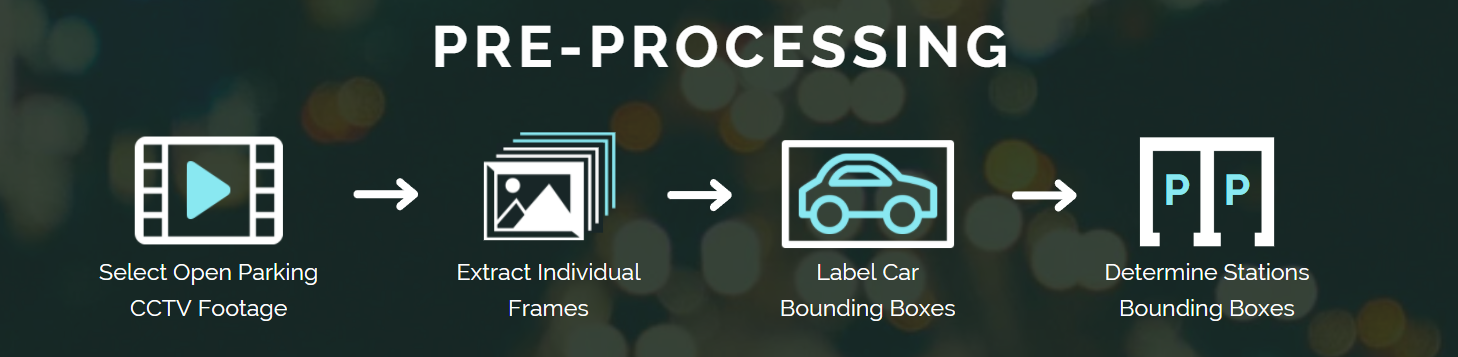

In [9]:
display(Image(filename="img/prep.PNG"))

<h3 style='background-color:#122926'><font color='#89e8f1'> A. CCTV Footage </font></h3>

<p style="text-align:justify">The first step involves picking a parking lot CCTV video footage on YouTube. For this project, we selected a video of an open parking lot with a clear view and angle. The team chose a video with an acceptable number of parked cars and occurrences of cars parking and leaving to fully test and demonstrate what the model could do. The video downloaded was 2 minutes and 35 seconds long with a frame rate of 15 frames per second.</p>

<h3 style='background-color:#122926'><font color='#89e8f1'> B. Sampling Frames </font></h3>

<p style="text-align:justify">The next step involves sampling video frames from the original video. OpenCV was used to read or scan the video frame by frame and then save frame images every 15 frames which is equivalent to every minute. A total of 156 frame images were collected from the video.</p>

In [ ]:
#  extract frame images from video

path = ''# redacted

vidcap = cv2.VideoCapture(path + '/parking_lot.mp4')
success, image = vidcap.read()
count = 0
frame_num = 0
while success:
    if count % 15:
        success, image = vidcap.read()
        cv2.imwrite(path + 'frame%d.jpg' % frame_num, image)
        frame_num += 1
    count += 1

<h3 style='background-color:#122926'><font color='#89e8f1'> C. Manual Labeling Vehicle Frames </font></h3>

<p style="text-align:justify">For each frame image, we manually labeled the vehicles with bounding boxes which will serve as our training set. We used the open-source graphical image annotation tool, <b> LabelImg </b> to do this. In this tool, annotations could be saved in several formats which includes the YOLO format. Each vehicle was manually labeled as a car by enclosing it in a bounding box for each frame. An example of the corresponding bounding boxes can be seen below. </p>

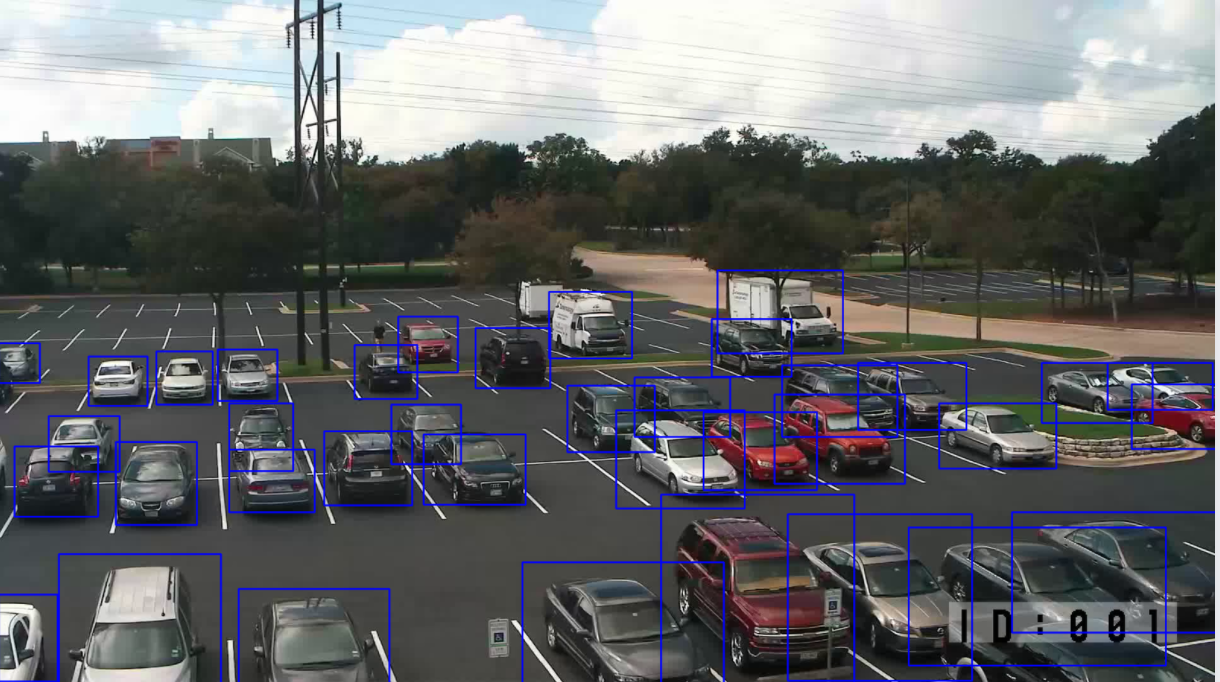

In [7]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 1. Manually Labeled Car Bounding Boxes.
</b></center>'''))

display(_image(filename="img/bb1.PNG"))

<h3 style='background-color:#122926'><font color='#89e8f1'> D. Manual Labeling of Lots </font></h3>

<p style="text-align:justify">Meanwhile, another important component of the model, which are the parking spaces/lots, needed to be manually labeled as well. The parking spaces were marked with bounding boxes as well, but the challenge was that their boxes were not regular rectangles and squares as their angles are distorted due to the camera angle. The four bounding box corner coordinates and their corresponding parking lot ID numbers were manually listed for each lot in an excel file and then plotted against the image. The lots only need to be labeled once because the view of the camera does not change overtime. The parking spaces look like those in the image below, using irregular quadrilaterals as the bounding boxes.</p>

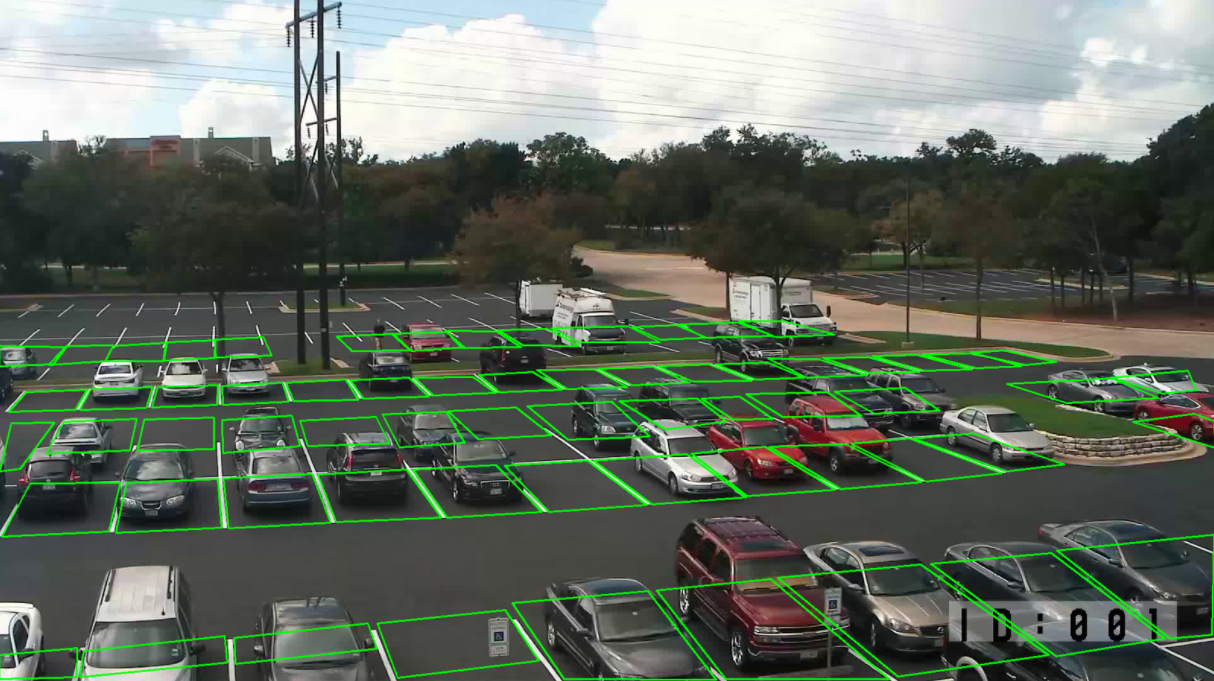

In [5]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 2. Manually Labeled Parking Slot Bounding Boxes.
</b></center>'''))

display(_image(filename="img/bb2.PNG"))

<h2 style='background-color:#122926'><font color='#89e8f1'> III. Methodology </font></h2>

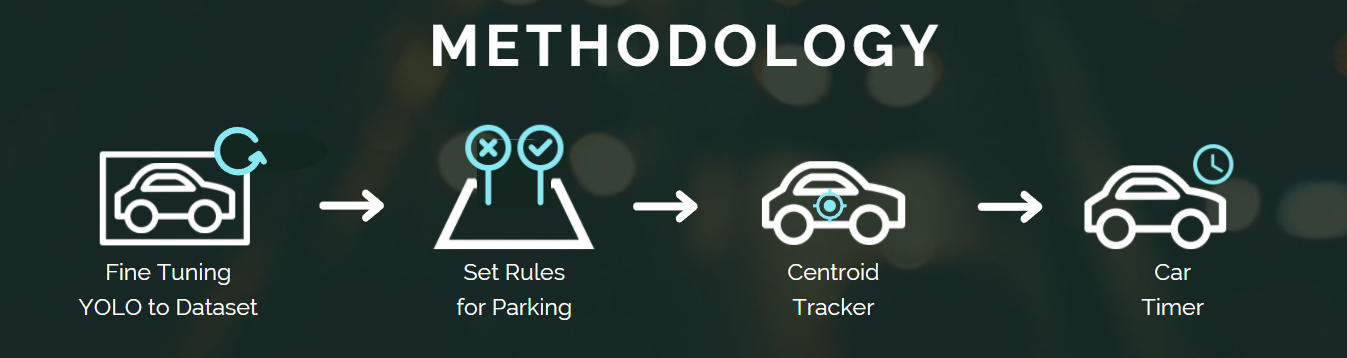

In [3]:
display(Image(filename="img/method.PNG"))

<h3 style='background-color:#122926'><font color='#89e8f1'> A. Pre-trained YOLO on COCO dataset</font></h3>

<p style="text-align:justify">YOLO has pre trained model on COCO dataset which could classify <a href="https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda">80 objects</a>. <a href="https://cocodataset.org/#home">COCO</a> dataset is a large scale object detection, segmentation, and captioning of over 330k images. One of the objects that the YOLO trained on this dataset could classify is car which is what we need for this study. Let us try to use if it would work well on our dataset.</p>

In [ ]:
# use if you want to use default settings
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

In [ ]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", 
                                                  "cfg/coco.data", 
                                                  "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
    darknet_image = make_image(width, height, 3)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

    # get image ratios to convert bounding boxes to proper size
    img_height, img_width, _ = img.shape
    width_ratio = img_width/width
    height_ratio = img_height/height

    # run model on darknet style image to get detections
    copy_image_from_bytes(darknet_image, img_resized.tobytes())
    detections = detect_image(network, class_names, darknet_image)
    free_image(darknet_image)
    return detections, width_ratio, height_ratio

In [ ]:
# evaluate in validation set
%cd /content/darknet
!./darknet detector map data/obj.data cfg/yolov4-csp.cfg ../yolov4-csp.weights -points 0

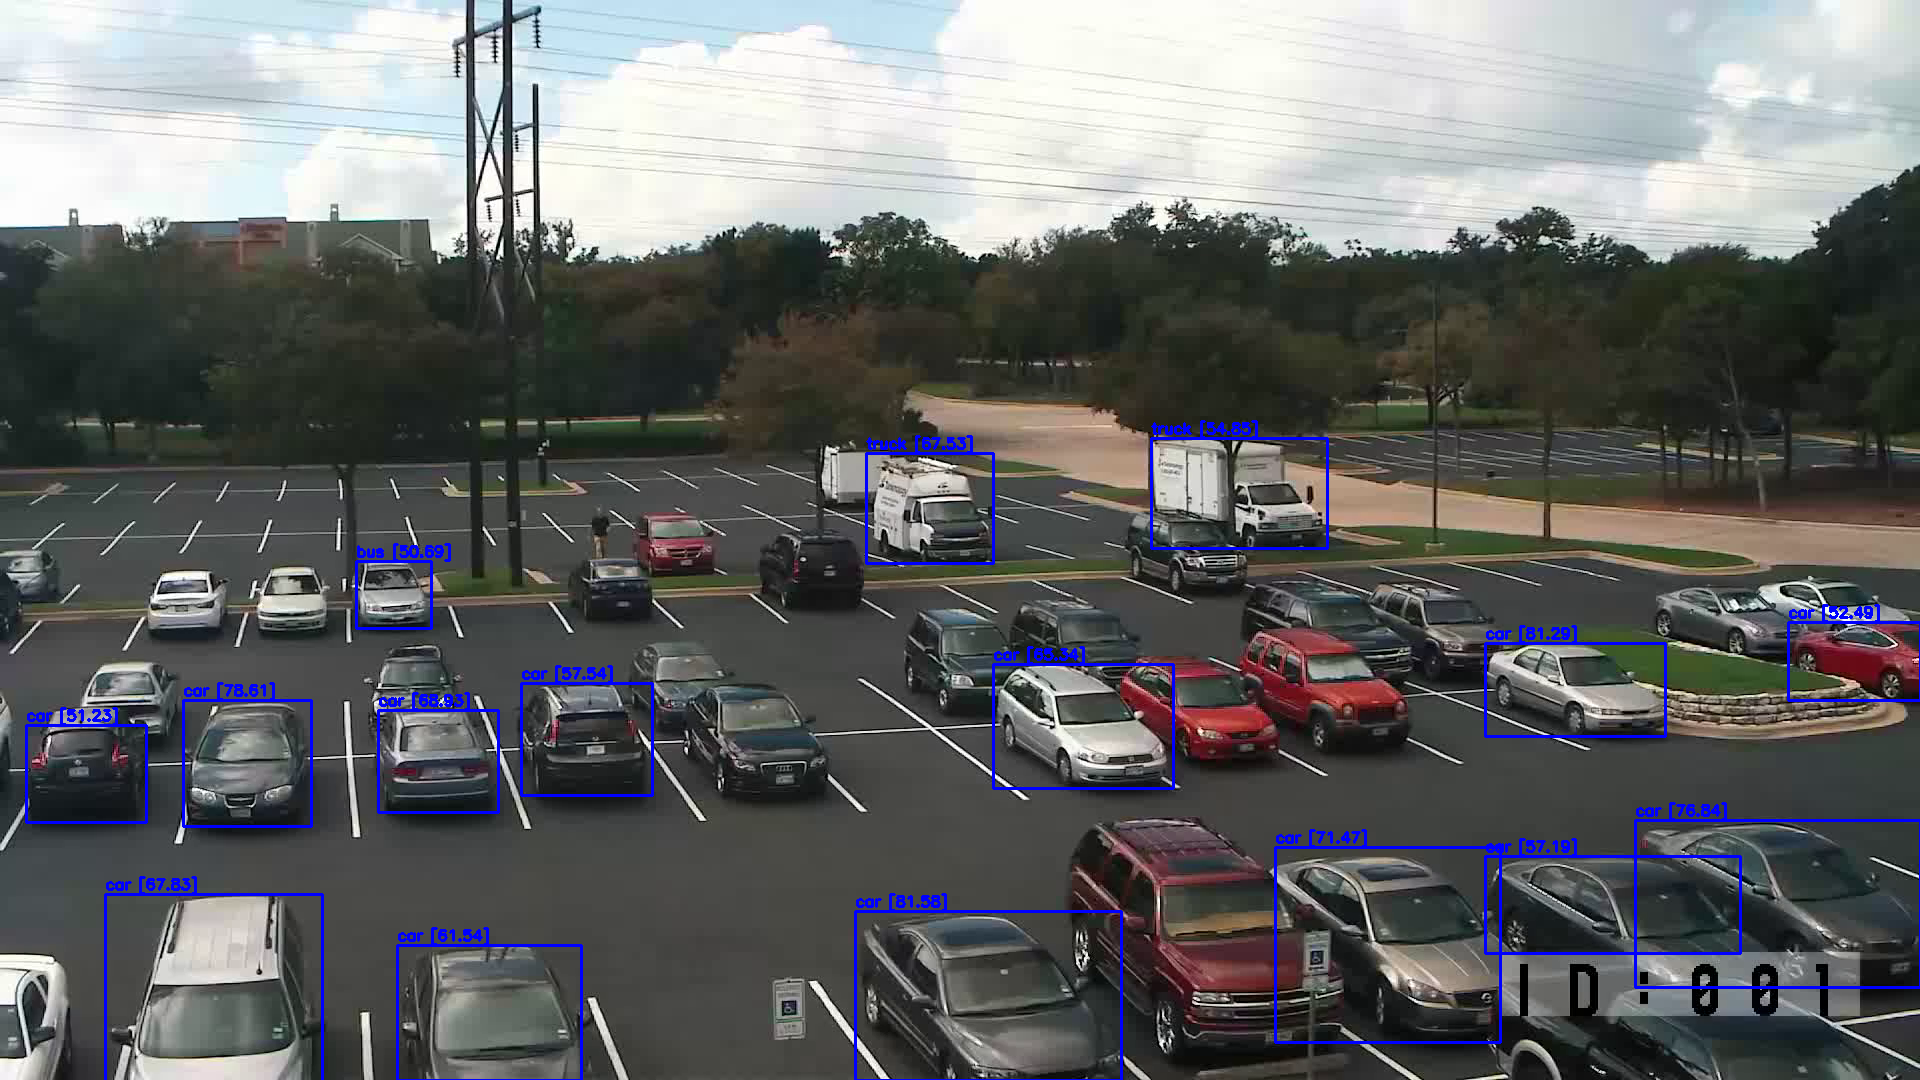

In [2]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 3. Output of Pretrained YOLO on COCO dataset.
</b></center>'''))

display(Image('img/pre_trained.png'))

<p style="text-align:justify">It turns out that majority of the cars were misclassified by the pre-trained model. Although the model is trained on thousand of images, it was not really trained on this type of environment and probably not to all angles and types of cars. </p>

<h3 style='background-color:#122926'><font color='#89e8f1'> B. YOLO Transfer Learning</font></h3>

<p style="text-align:justify">To remedy the issues found in using pretrained model on COCO dataset, we can perform training on custom dataset. The detailed explanation on how to train your YOLO on custom dataset can be found in their <a href="https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects">documentation</a>.</p>

<b>Train and Test Split</b>

<p style="text-align:justify">The data that we used for training and evaluation of our custom model are the manually labelled bounding boxes images from the CCTV footage of parking lot. The Darknet implementation of YOLO supports validation set. It can be done by creating <code>train.txt</code> and <code>test.txt</code> that contains the filename of the images. Since we only have 150 images, we decided to use 10 percent or 15 images as the validation set in order to give more importance on the training of the data.</p> 

In [ ]:
# Percentage of images to be used for the test set
percentage_test = 10

# Create and/or truncate train.txt and test.txt
file_train = open('./data/train.txt', 'w')
file_test = open('./data/test.txt', 'w')

# Populate train.txt and test.txt
counter = 1
index_test = round(100 / percentage_test)
for pathAndFilename in glob.iglob(os.path.join('data/', "*.jpg")):
    title, ext = os.path.splitext(os.path.basename(pathAndFilename))

    if counter == index_test:
        counter = 1
        file_test.write("data/obj" + "/" + title + '.jpg' + "\n")
    else:
        file_train.write("data/obj" + "/" + title + '.jpg' + "\n")
        counter = counter + 1

file_train.close()
file_test.close()

<b>Define configurations</b>

<p style="text-align:justify">We used the suggested configurations of darknet which is <code>cfg/yolov4-custom.cfg</code> and adjusted the parameters as discussed in the documentation. Aside from the configurations we also defined <code>obj.names</code> and <code>obj.data</code>.</p>

<b>Train the model</b>

<p style="text-align:justify">The model training can be performed by using the <code>detector train</code> command which expects at least three parameters: data, configurations, and initial weights. Initially we used <code>yolov4.conv.137</code> as the pre trained weights which is trained in COCO dataset. Then we retrained the weights to further improve the results. Overall it took about three hours of training to get a good result.</p>

In [ ]:
# train by transfer learning from weights trained on coco dataset by darknet
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map

In [ ]:
# continue training model by transfer learning from weights trained on custom dataset
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg  backup/yolov4-obj_last.weights -dont_show -map

In [ ]:
# backup saved weights
!cp backup/yolov4-obj_1000.weights /content/drive/MyDrive/MSDS/ML3/final_project/yolov4-obj_1000.weights
!cp backup/yolov4-obj_1000.weights /content/drive/MyDrive/MSDS/ML3/final_project/yolov4-obj_best.weights
!cp backup/yolov4-obj_1000.weights /content/drive/MyDrive/MSDS/ML3/final_project/yolov4-obj_last.weights

# copy mean average precision per epoch
!cp chart.png /content/drive/MyDrive/MSDS/ML3/final_project/chart_trained.png

<b>Evaluate model</b>

<p style="text-align:justify">Mean average precision is a common metric used in object detection model. It gets the average precision at varying threshold of confidence at a specific Intersect over Union (IoU) and get the mean across all of the detected classes. In our case, average precision and mean average precision are equal since we are only looking for one class</p>

In [ ]:
# evaluate in validation set
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg backup/yolov4-obj_best.weights -points 0

<p style="text-align:justify">The results that we got is a 100 percent precision in the validation set. Remember that we only have fifteen images for validation set and it could be that the validation set is easy to detect. We will see if our model still performs well in the following sections.</p>

<h3 style='background-color:#122926'><font color='#89e8f1'> C. Set Rules and Features</font></h3>

<p style="text-align:justify">We need to set up a rule to determine if the parking lot is occupied or vacant. We first checked if the parking lot and the car has a intersection, then for each row of the parking space we created a threshold since the angle or our camera is not levelled, finally we get count the car with highest IoU with the parking lot. </p>

In [ ]:
stations = pd.read_excel('/content/Station Coordinates.xlsx',
                         header=None, sheet_name=2)
p1 = stations.iloc[:, 0:2].values.tolist()
p2 = stations.iloc[:, 2:4].values.tolist()
p3 = stations.iloc[:, 4:6].values.tolist()
p4 = stations.iloc[:, 6:8].values.tolist()
p5 = stations.iloc[:, 8].values.tolist()

def apply_rect(x1, y1, x2, y2):
    """ convert bounding boxes to coordinates
    
    Parameters 
    ==========
    x1        :    int
                   left coordinate
    y1        :    int
                   top coordinate
    x2        :    int
                   right
    y2        :    int
                   bottom
                   
    Returns
    =======
    apply_rect :   list
                   list of coordinates
    """
    p1, p2, p3, p4 = [[x1, y1], [x1, y2], [x2, y2], [x2, y1]]
    return [p1, p2, p3, p4]

def validate(station, bb, thresh_bot, thresh_top, row):
    """ validate if the station is parked
    
    Parameters
    ==========
    station    :    list
                    station coordinates
    bb         :    list
                    car coordinates
    thresh_bot :    list
                    threshold of bottom per row
    thresh_top :    list
                    threshold of top per row
    row        :    int
                    row number
    """
    if ((row == 0) 
        and (abs(station[3][1] - bb[1][1]) < thresh_bot)):
        return True
    elif ((row == 1)
         and (abs(station[3][1] - bb[1][1]) < thresh_bot)
         and (abs(station[0][1] - bb[0][1]) > thresh_top)):
        return True
    elif ((row == 2)
         and (abs(station[3][1] - bb[1][1]) < thresh_bot)
         and (abs(station[0][1] - bb[0][1]) < thresh_top)):
        return True
    elif ((row == 3)
          and (abs(station[3][1] - bb[1][1]) < thresh_bot)):
        return True
    elif ((row == 4)
          and (abs(station[3][1] - bb[1][1]) < thresh_bot)):
        return True
    
    return False  

In [ ]:
for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = (int(left * width_ratio), 
                                int(top * height_ratio), 
                                int(right * width_ratio), 
                                int(bottom * height_ratio))
    detections_bb.append({
            'x1' : left,
            'y1' : top,
            'x2' : right,
            'y2' : bottom
        })

ious = []
detections_bb = [apply_rect(*i.values()) for i in detections_bb]
for bb in tqdm(detections_bb):
    temp_iou = []
    temp_station = []
    polys = [i for i in zip(p1, p2, p3, p4)]
    polys_list = [polys[0:13], polys[13:30], polys[30:44], 
             polys[44:56], polys[56:65]]
    threshs_bot = [45,25,45,55,90]
    threshs_top = [None, 50, 60, None, None]
    for i, (station_polys, 
            thresh_bot, 
            thresh_top) in enumerate(zip(polys_list, 
                                         threshs_bot, threshs_top)):
        bb_poly = Polygon(bb)
        for station in station_polys:
            station_poly = Polygon(station)
            if (bb_poly.intersection(station_poly)
               and validate(station, bb, thresh_bot, thresh_top, i)):                    
                intersection_ = bb_poly.intersection(station_poly).area
                union_ = bb_poly.union(station_poly).area
                IOU = (intersection_ / union_)
                temp_iou.append(IOU)
                temp_station.append(station)
    if temp_iou:
        ious.append([bb,
                     temp_station[np.argmax(temp_iou)],
                     max(temp_iou)])

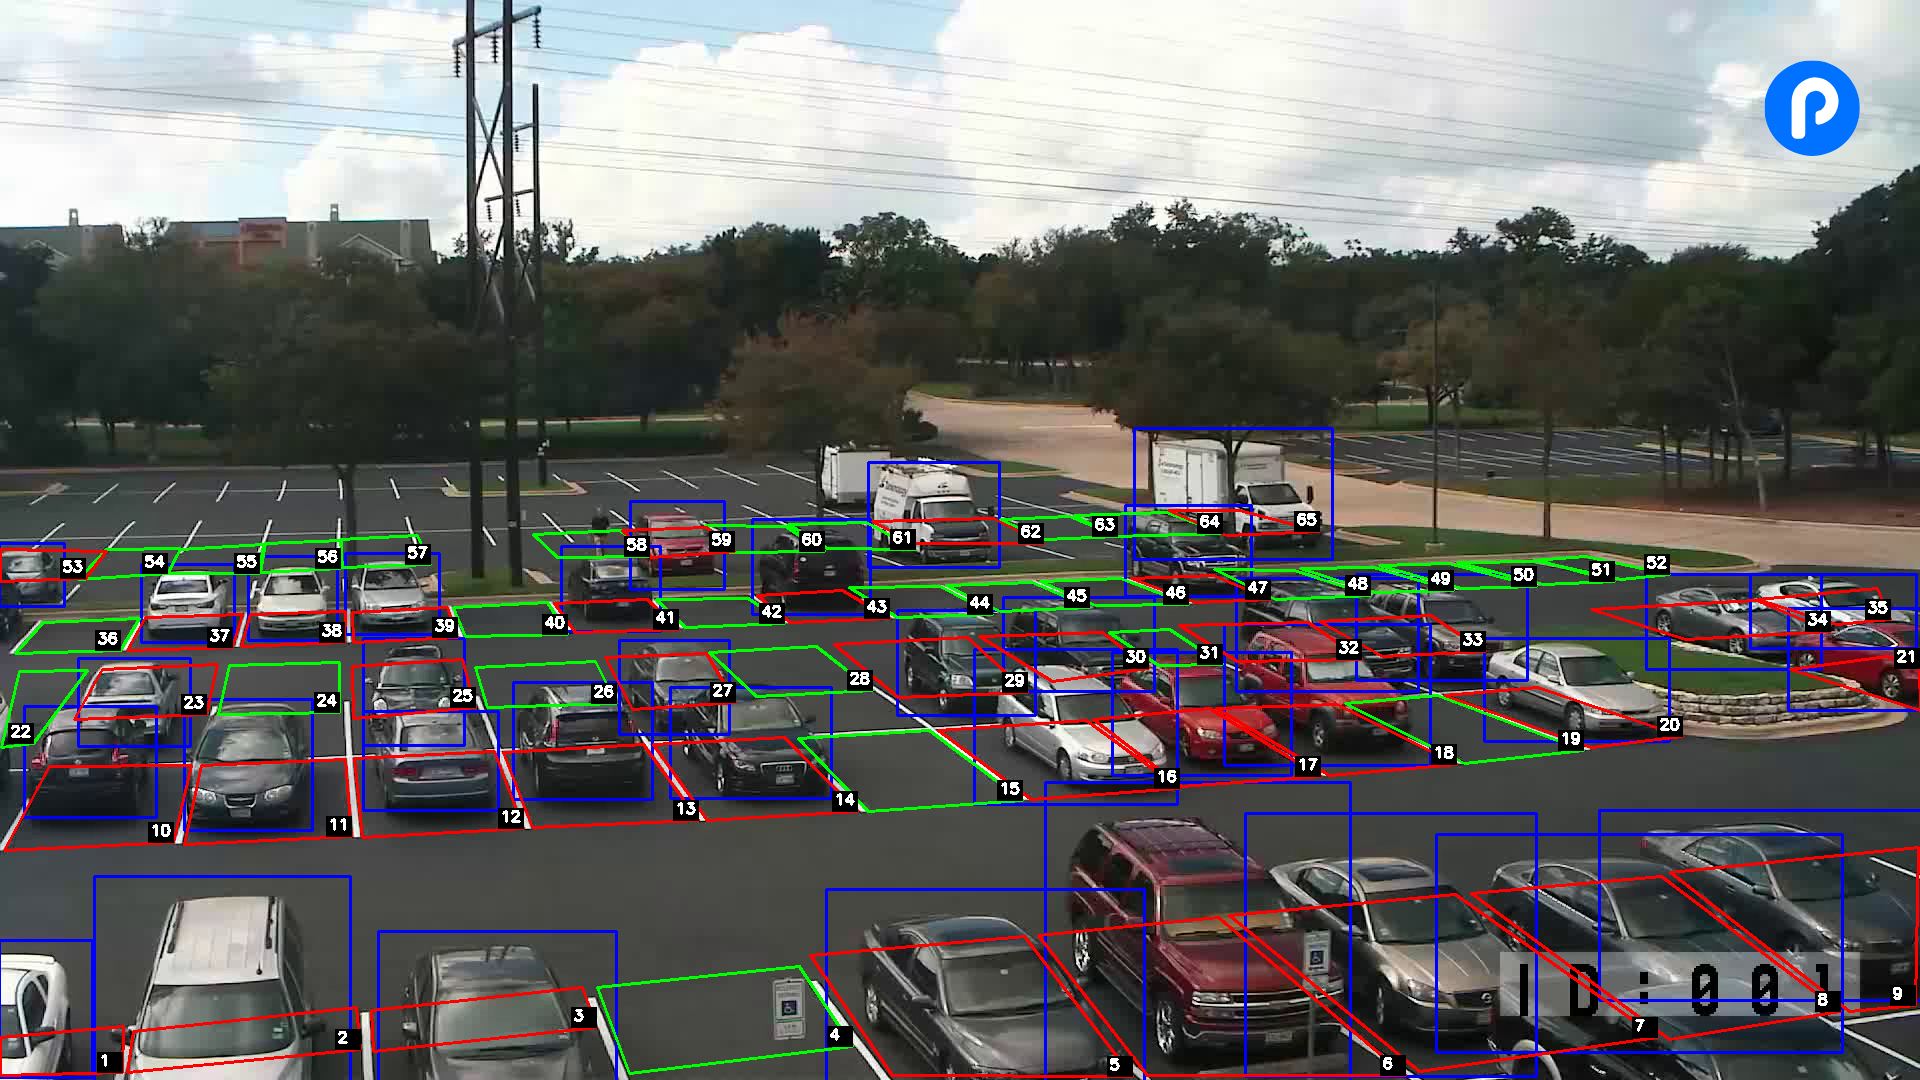

In [11]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 4. Output of Rules for Bounding Boxes for Cars and Parking Lots.
</b></center>'''))

display(Image('img/13.png'))

<h3 style='background-color:#122926'><font color='#89e8f1'> D. Centroid Tracker</font></h3>

<p style="text-align:justify">In order to introduce unique object tracking to our YOLO model, we implemented CentroidTracker using the <a href="https://github.com/adipandas/multi-object-tracker">multi-object-tracker</a> package. The package works natively with YOLOv3 by assigning a unique ID for each detected object while calculating the centroid of the object based on the dimensions of the generated bounding box when it is generated.</p>

In [ ]:
!git clone https://github.com/adipandas/multi-object-tracker
%cd multi-object-tracker
!pip install -r requirements.txt
!pip install -e .
%cd /content/multi-object-tracker

In [ ]:
from motrackers.detectors import YOLOv3
from motrackers import CentroidTracker, CentroidKF_Tracker, SORT, IOUTracker
from motrackers.utils import draw_tracks
tracker = CentroidTracker(max_lost=0, tracker_output_format='mot_challenge')

<p style="text-align:justify">To make it compatible with YOLOv4 we made some preprocessing on the expected points of the multi-object tracker package like adjustments on width and height ratio of the image.</p>

In [ ]:
%cd /content/
cap = cv2.VideoCapture('parking_lot.mp4')
success,frame = cap.read()
# get the predicted detections of the trained custom yolo
detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

bbox_list = []
for i in detections:
    bbox_list.append(list(i[2]))

bbox_conv = []
for i in bbox_list:
    left, top, right, bottom = i
    left, top, right, bottom = (int(left * width_ratio), 
                        int(top * height_ratio), 
                        int(right * width_ratio/2), 
                        int(bottom * height_ratio/2))
bbox_conv.append([left, top, right, bottom])


conf_list = []
for i in detections:
    conf_list.append(float(i[1]))

class_list = np.zeros_like(np.array(conf_list)) 

tracks = tracker.update(bbox_conv, conf_list, class_list)

<h3 style='background-color:#122926'><font color='#89e8f1'> E. Timer</font></h3>

<p style="text-align:justify">Now that we have the unique ID for each detected car, we can now attach a timer to it as soon as the car enters the parking lot for a possible automatic checkout of the cars in the parking lot. The CCTV camera that we used has a 15 fps which is one of the standard of a CCTV. Using that information, we count the number of frames a car is inside the parking lot then for every 15 frames we count that as 1 second.</p>

In [ ]:
cent_bbox = []
ids = []
for track in tracks:
    left = track[2]
    top = track[3]
    right = track[2] + track[4]
    bottom = track[3] + track[5]
    cent_bbox.append([[left, top], [right, top], 
                    [right, bottom], [left,bottom]])
    ids.append(track[1])


cent_ious = []

for id, bbox in zip(ids, cent_bbox):
    if id not in id_counter.keys():
        id_counter[id] = [timedelta(0), 0]
    temp_iou = []
    temp_cent = []
    cent_poly = Polygon(bbox)
    for bb in detections_bb:
        bb_poly = Polygon(bb)
        if bb_poly.intersection(cent_poly):
            intersection_ = bb_poly.intersection(cent_poly).area
            union_ = bb_poly.union(cent_poly).area
            IOU = (intersection_ / union_)
            temp_iou.append(IOU)
            temp_cent.append(bb)
    if temp_iou:
        cent_ious.append([bbox,
                    temp_cent[np.argmax(temp_iou)],
                    id])

for key in id_counter.keys():
    id_counter[key][1] += 1
    if id_counter[key][1] == 15:
        id_counter[key][1] = 0
        id_counter[key][0] += timedelta(seconds=1)

for i in cent_ious:
    cv2.putText(frame, f"[{id_counter[i[2]][0]}]",
                (int(i[1][0][0]), int(i[1][0][1])),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255, 255), 2)

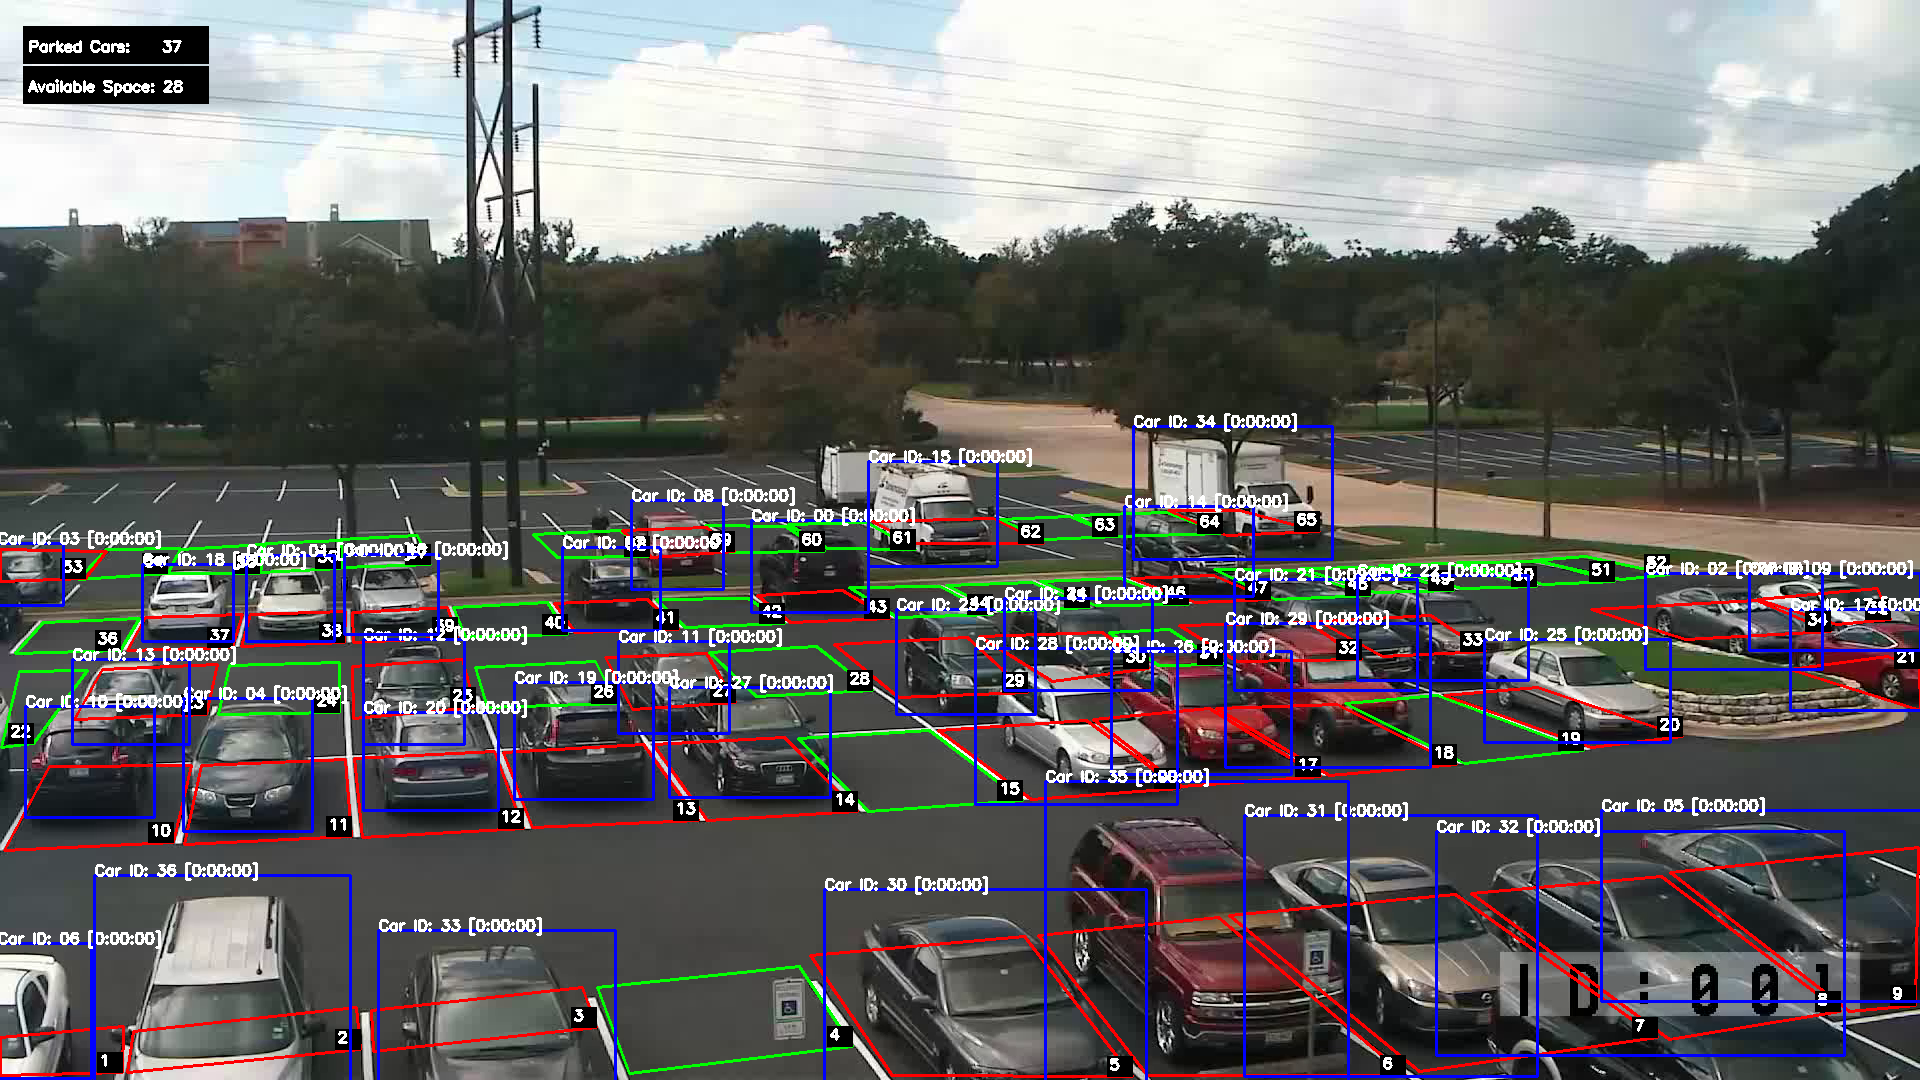

In [13]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 5. Unique IDs and Timers for Each Car.
</b></center>'''))

display(Image('img/15.png'))

<h2 style='background-color:#122926'><font color='#89e8f1'> IV. Results and Discussion </font></h2>

<p style="text-align:justify">The application of transfer learning on a pre-trained model has allowed for high precision of 100% on the validation set with fast detection. This allows for robust and real-time detection when deployed as a real-time car tracker. This is one of the reasons why YOLO was chosen as the pre-trained object detection model.</p>
    
<p style="text-align:justify">The use of rules to detect cars is based on the collision of the bounding boxes of the cars and the parking lots. This is measured as the intersection over union (IoU) and the distances of the corners of the bounding boxes of the cars and the lots. A threshold is set for each one to prevent cars that are moving through to take over lots. These rules can also be set to different rows or even specific lots depending on the scope of the camera. In our case as a proof of concept, we maximized the view the camera allowed which presented a challenge in fine tuning the thresholds mentioned.</p>

<p style="text-align:justify">The next challenge was to be able to identify cars and assign a unique ID. In this way, we can determine the time it takes for them to stay inside the parking lot. YOLO is not capable of this so we employed the <a href = https://github.com/adipandas/multi-object-tracker>Multi-Object Tracker</a> library. This relies on the tracking of bounding box centroids to be able to assign a unique ID to each car. Since each frame would only allow for small deviations in distances of the centroids, a moving car can be tracked continuously. This breakthrough in our implementation now allowed us to be able to track the time a car stayed inside their lot or even the parking lot itself. This allows us to attach a timer for each centroid or unique ID.</p>

<p style="text-align:justify">Optimization of the for loops can still be done for each frame be able to process in real time.</p>

In [15]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 6. Final Output Video for Park EZ.
</b></center>'''))

display(Video('img/parking_cctv_timer (2).mp4'))

<h2 style='background-color:#122926'><font color='#89e8f1'> V. Conclusion </font></h2>

<p style="text-align:justify">This methodology is a proof of concept of the use of computer vision for real time parking management. The use of bounding boxes and centroid tracking can track and time each car.</p>

<b>Insights</b>
1. Proper camera positioning is crucial for the implementation and creating CCTV footage. The height and angle determines the shape of the bounding boxes of the parking lots. It also determines the view of the cars that will be seen in the footage.

2. Based on the camera positioning as well, the thresholds for rules between the bounding boxes will be tuned on the CCTV footage at hand. Edge cases such as cars blocking each other or improper parking need to be addressed depending on the footage at hand.

3. Perspective also distorts the views of the parking lot. The farther the object is from the field of view, the more skewed it is on camera. Therefore it affects the training data for car recognition and the shape of the bounding box.

4. Therefore, a good solution for this would be to distribute cameras in the parking lot to maximize and optimize service capacity. This could be convenient for open parking lots that already have a system of light poles that are distributed throughout the lot for maximum coverage because that means the spacing is already optimized.

<h2 style='background-color:#122926'><font color='#89e8f1'> VI. Recommendations </font></h2>

<p style="text-align:justify">This section is divided into Future Improvements and Other Use Cases. The former suggests additional features that can be implemented that build on top of an automated car parking management system. The later explores use cases which our current implementation can be slightly modified to tackle.</p>

<b>Future improvements</b>
    
1. <p style="text-align:justify">Security Monitoring - Raises alerts for suspicious loitering occurring near the parking space. This may be done by further modifying the YOLO implementation by classifying people and setting an additional rule that raises an alarm when a detected person is detected to be loitering near a parked car over a specified time.</p>
    
2. <p style="text-align:justify">Camera Network - This implementation explores multiple YOLO implementations that covers a network of multiple camera systems covering multiple angles of a parking lot simultaneously. This would explore camera feed coverage coming from multiple angles and stitching together the outputs from different YOLO deployment for consistent coverage and tagging throughout the different camera feeds.
    
3. <p style="text-align:justify">User App - A user facing app that informs users about their parking usage which is implemented through the unique ID tagging and timer. This may tie into a payment gateway integrated in the system.</p>


<b>Other use cases</b>
1. <p style="text-align:justify">Employee Detection - The original exploration for this system was used for monitoring employees while they’re at their workstation. The implementation detected workspaces as stations while the YOLO algorithm was trained to detect people. The collision rules were set to detect when employees would stay or leave their workstation as a form of monitoring.</p>

2. <p style="text-align:justify">Security Systems - This deployment would retool the implementation by setting stations in restricted areas which would raise alerts when detected people would trespass in these restricted areas set by collision rules.</p>

3. <p style="text-align:justify">Traffic Management - Stations and collision rules may be set to determine illegal parking, traffic violations, and many other use cases to serve as decision support in target roads.</p>

<h2 style='background-color:#122926'><font color='#89e8f1'> References </font></h2>

Adipandas. (n.d.). Adipandas/multi-object-tracker: Multi-object trackers in python. GitHub. Retrieved March 21, 2022, from https://github.com/adipandas/multi-object-tracker 

Advanced parking management systems cost between \\$250 and \$800 per parking space to install. Welcome to U.S. Department of Transportation. (n.d.). Retrieved March 21, 2022, from https://www.itskrs.its.dot.gov/its/benecost.nsf/ID/ee8ccecead836eb6852573e2006bc427 

Canivel, R. S. C. (2022, January 13). Vehicle sales up 20% in 2021, but 'soft' growth worries analyst. INQUIRER.net. Retrieved March 21, 2022, from https://business.inquirer.net/338682/vehicle-sales-up-20-in-2021-but-soft-growth-worries-analyst 

Logical increments PC buying guide. Logical Increments. (n.d.). Retrieved March 21, 2022, from https://www.logicalincrements.com/ 

Quantum. (2019, January 21). Comparing object detection models' performance on different gpus. Medium. Retrieved March 21, 2022, from https://medium.datadriveninvestor.com/comparing-object-detection-models-gpus-935754ae2677 

Redmon, J. (n.d.). Yolo: Real-time object detection. Retrieved March 21, 2022, from https://pjreddie.com/darknet/yolo/ 

Tzutalin. (n.d.). Tzutalin/labelimg: 🖍️ LabelImg is a graphical image annotation tool and label object bounding boxes in images. GitHub. Retrieved March 21, 2022, from https://github.com/tzutalin/labelImg 